# Logistic Regression and SGD Homework 
***
**Name**: $<$Cory Mosiman$>$ 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [40]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [41]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

**Problem 1 Answer**

In [183]:
print('There are {} words in the vocabulary.'.format(len(vocab)))

There are 5327 words in the vocabulary.


The code is using a bag-of-words model.  Both the positive and negative files have a 'word':'count' per line format.  Additionally, observing the assignment of `self.x` in `class Example`:  

`for word, count in [x.split(":") for x in words]:  
   if word in vocab:
      self.x[vocab.index(word)] += float(count)`
        
`self.x` is a numpy array containing the total count of the word in the line. Indices of `self.x` correspond to the indices of the word in the vocab list.  This is consistent with a bag-of-words model, since a binary model would just include a `1` if the word appears in the document.

In order to determine which label refers to automobiles or motorcycles, I performed a search of the positive and negative text files for specific words and recorded their counts.  When I searched for the words, I primarily thought the following categories would apply.

Motorcycle words:
- rider(s)
- bike(s)
- chief
- scout
- indian

Automobile words:
- automobile(s)
- car(s)
- driver(s)
- window(s)

| word          | negative | positive |
|---------------|----------|----------|
| rider(s)      | 1        | 92       |
| car(s)        | 627      | 213      |
| automobile(s) | 33       | 1        |
| driver(s)     | 93       | 37       |
| window(s)     | 39       | 21       |
| windshield(s) | 12       | 4        |
| bike(s)       | 7        | 396      |
| chief         | 0        | 7        |
| scout         | 1        | 6        |
| indian        | 0        | 10       |
| chassis       | 8        | 1        |

From the counts table above:  
- Motorcycle = positive (1)
- Automobile = negative (0)

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [296]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        ## Perform gradient update
        # compute dot product
        dot = np.dot(np.transpose(self.w), train_example.x)
        
        # pull out non-zero and zero keys
        nz_keys = list(train_example.nonzero.keys())
        z_keys = [key for key in range(1,len(train_example.x)) if key not in nz_keys]
        self.last_update
        
        # w = w - eta*(sigm(w*x) - y)*x
        self.w[0] = self.w[0] - self.eta*(self.sigmoid(dot) - \
                                          train_example.y)*train_example.x[0]
        self.w[nz_keys] = self.w[nz_keys] - self.eta*(self.sigmoid(dot) - \
                                            train_example.y)*train_example.x[nz_keys]
        
        ## Perform regularization update if lam specified
        if self.lam != 0:
            
            # initialize dictionary
            if iteration == 0:
                for nz_key in nz_keys:
                    self.last_update[nz_key] = 0
                for z_key in z_keys:
                    self.last_update[z_key] = 0

            # iterate through non-zero keys and regularize. Keep track of last_update
            for nz_key in nz_keys:
                power = iteration + 1 - self.last_update[nz_key]
                self.w[nz_key] = self.w[nz_key] * ((1 - 2*self.lam*self.eta) ** power)
                self.last_update[nz_key] += 1
                
        return self.w
        

In [ ]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [237]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [ ]:
lr = LogReg(train_set, test_set, lam=0.25, eta=0.1)
lr.train(isVerbose=True)

In [238]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

**Answer:**  
The three graphs below show the effect of the regularization parameter on the test accuracy.  At very small values of lambda, the regularized logistic regression model performs better.  For `lambda = [0, 1.0E-03]`, the model test accuracy is very similar, ranging from 0.931 to 0.957.  The highest accuracy of 0.957 is achieved with `lambda = 0`, i.e. no regularization.  However, with `lambda = 1.0*10E-3`, the model achieves an accuracy of 0.948, a very close result.  At values near `lambda = 1`, the model performs very poorly.  This is likely caused by the relatively small magnitude of the feature set.

In [339]:
# create a generator object looping through powers of 10
def lamb_range(start_power, end_power):
    power = start_power
    yield 0
    while power < end_power:
        yield (10 ** power)
        power += 3

# define upper and lower bound of exponents
low = -9
high = 1

# initiate generator object and evaluate LogReg at different levels
test_range = lamb_range(low, high)
tests = {}
for lamb in test_range:
    tests[lamb] = LogReg(train_set, test_set, lam = lamb, eta = 0.1)
    tests[lamb].train()

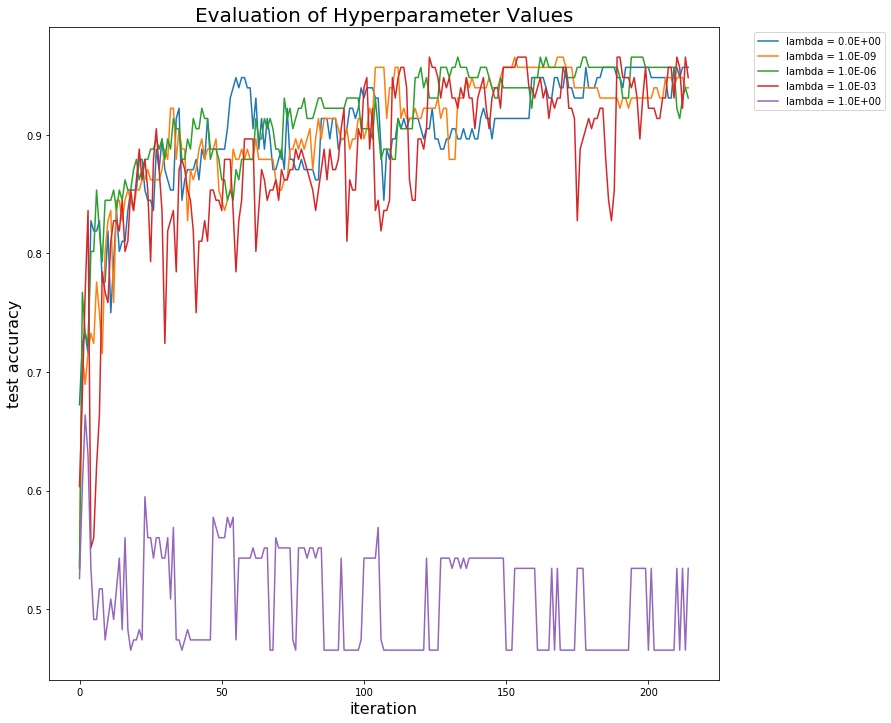

In [366]:
# re-initiate generator object
test_range = lamb_range(low, high)

fig = plt.figure(figsize=(12,12))
for each in test_range:
    x = list(range(0,len(tests[each].train_acc)))
    plt.plot(x, tests[each].test_acc, label = 'lambda = {:.1E}'.format(each,))
plt.legend(loc = 9, bbox_to_anchor = (1.15, 1.0))
plt.title('Evaluation of Hyperparameter Values', fontsize = 20)
plt.xlabel('iteration', fontsize = 16)
plt.ylabel('test accuracy', fontsize = 16)
plt.show()

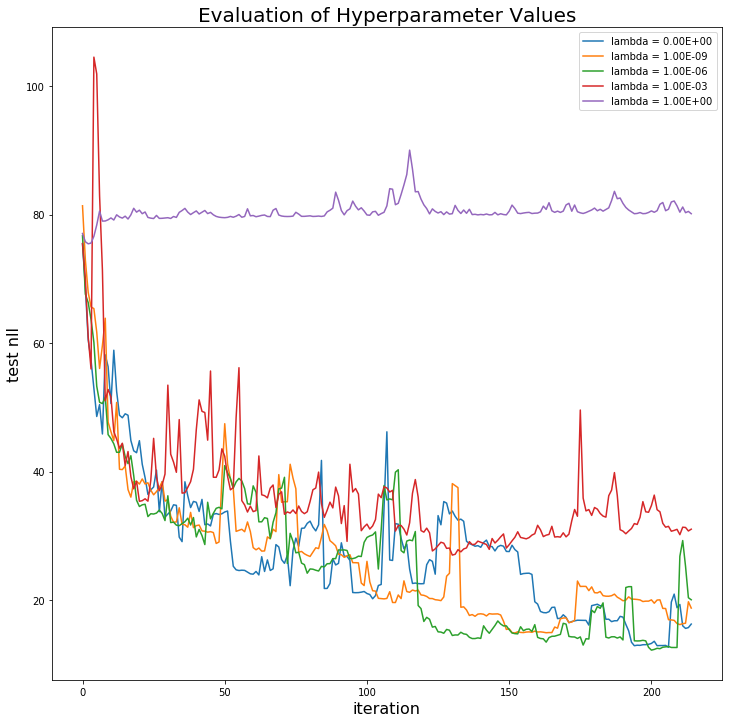

In [341]:
test_range = lamb_range(low, high)
fig = plt.figure(figsize=(12,12))
for each in test_range:
    x = list(range(0,len(tests[each].test_nll)))
    plt.plot(x, tests[each].test_nll, label = 'lambda = {:.2E}'.format(each))
plt.legend(loc = 'best')
plt.title('Evaluation of Hyperparameter Values', fontsize = 20)
plt.xlabel('iteration', fontsize = 16)
plt.ylabel('test nll', fontsize = 16)
plt.show()

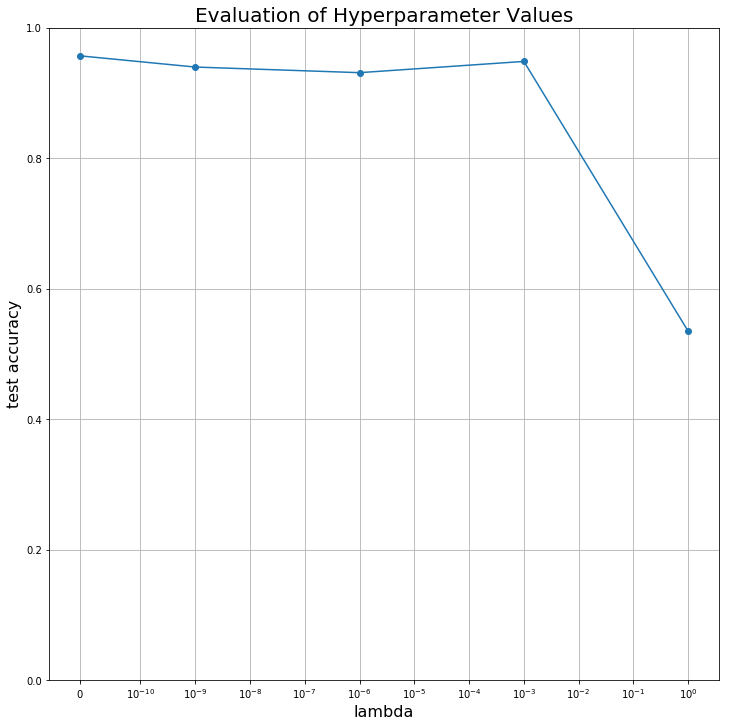

0

In [365]:
test_range = lamb_range(low, high)
fig = plt.figure(figsize=(12,12))
final_acc = []
lambs = []
for each in test_range:
    final_acc.append(tests[each].test_acc[-1])
    lambs.append(each)
    
plt.plot(lambs, final_acc, linestyle = '-', marker ='o')
plt.title('Evaluation of Hyperparameter Values', fontsize = 20)
plt.xlabel('lambda', fontsize = 16)
plt.ylabel('test accuracy', fontsize = 16)
plt.grid(True)
plt.xscale('symlog', linthreshx = 10 ** -10)
plt.ylim(0,1)
plt.show()

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

**Answer:**  
In general, the smaller the learning rate, the faster the SGD converges.  See plot below.

In [378]:
import time

low_eta = -5
high_eta = 5
eta_range = lamb_range(low_eta, high_eta)

# dictionary to store convergence time
timer = {}

# best performance with lambda = 0
lamb = 0

# iterate through values of eta
for eta in eta_range:
    start = time.time()
    tests[eta] = LogReg(train_set, test_set, lam = lamb, eta = eta)
    tests[eta].train()
    timer[eta] = time.time() - start


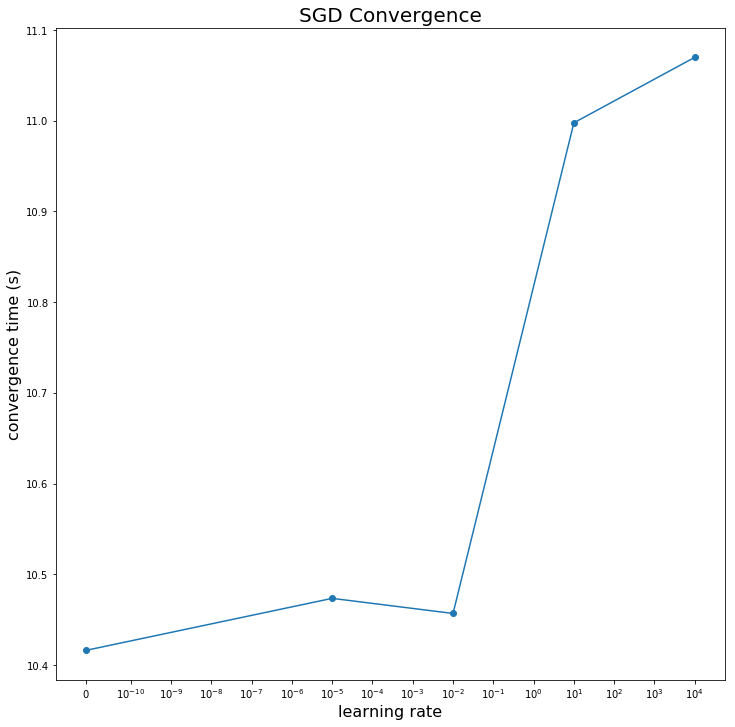

In [385]:
fig = plt.figure(figsize=(12,12))
eta_range = lamb_range(low_eta, high_eta)

eta_x = [x for x in eta_range]
plt.plot(eta_x, list(timer.values()), linestyle = '-', marker ='o')
plt.legend(loc = 'best')
plt.title('SGD Convergence', fontsize = 20)
plt.xlabel('learning rate', fontsize = 16)
plt.ylabel('convergence time (s)', fontsize = 16)
plt.xscale('symlog', linthreshx = 10 ** -10)
plt.show()

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

**Answer**  
Automobile label = 0, therefore, corresponding to negative coefficient values.  
Motorcycle lable = 1, therefore, corresponding to positive coefficient values.  

All we need to do is look for the 10 minimum and maximum values in the coefficients of the logistic regression model.

In [403]:
lr = LogReg(train_set, test_set, lam=0, eta=0.01)
lr.train()

In [442]:
best_moto = {}
best_auto = {}
    
maxdices = np.argsort(lr.w)[-10:]
for word in maxdices:
    best_moto[word] = vocab[word]
    
mindices = np.argsort(lr.w)[:10]
for word in mindices:
    best_auto[word] = vocab[word]


In [479]:
print('The 10 best predictors for automobile are:\n', list(best_auto.values()), '\n')
print('The 10 best predictors for motorcycle are:\n', list(best_moto.values()))

The 10 best predictors for automobile are:
 ['car', 'cars', 'ford', 'engine', 'oil', 'usa', 'dealer', 'toyota', 'price', 'wagon'] 

The 10 best predictors for motorcycle are:
 ['ca', 'dog', 'sun', 'helmet', 'rider', 'riding', 'ride', 'bikes', 'dod', 'bike']


**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

**Answer:**  
In the same context, all we need to do to find the worst predictors for each class is find the 10 positive and negative coefficients closest to zero.  Code is relatively simple and answers are printed below.

In [478]:
# create a copy of w in order to delete elements out of it
copy_w = lr.w

# initialize worst dictionaries for each label
worst_moto = {}
worst_auto = {}

# loop through copy_w until 
a = (np.abs(lr.w - 0)).argmin()
while len(worst_auto) < 10 or len(worst_moto) < 10:
    if copy_w[a] > 0:
        worst_moto[a] = vocab[a]
    else:
        worst_auto[a] = vocab[a]
    copy_w = np.delete(copy_w, a)
    a = (np.abs(copy_w)).argmin()

print('The ten worst predictors for automobile are:\n', list(worst_auto.values()), '\n')
print('The ten worst predictors for motorcycle are:\n', list(worst_moto.values()))

The ten worst predictors for automobile are:
 ['locate', 'roberts', 'rollover', 'towing', 'eagles', 'forgive', 'possibly', 'phrase', 'met', 'columbus'] 

The ten worst predictors for motorcycle are:
 ['cited', 'archive', 'sound', 'package', 'communication', 'balance', 'lots', 'timothy', 'garaged', 'hints', 'faraday', 'setup', 'corrected', 'standardized', 'bend']
